# Next-Frame Video Prediction with Convolutional LSTMs using Moving Mnist Dataset

https://keras.io/examples/vision/conv_lstm/ 



İmporting Necessary Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import tensorflow
import torch

## Dataset Construction

For this example, we will be using the
[Moving MNIST](http://www.cs.toronto.edu/~nitish/unsupervised_video/)
dataset.

We will download the dataset and then construct and
preprocess training and validation sets.

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [ ]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)
dataset = np.load(fpath)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y
# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

## Model Training

With our model and data constructed, we can now train the model.

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

## Save and load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/saved_models/convlstm_movingmnist_ready.h5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/saved_models/convlstm_movingmnist_ready.h5')

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

In [ ]:
import cv2
data=[]
vidcap = cv2.VideoCapture('/content/mnist_1004.mp4')
for count in range(0,20):
  success,image = vidcap.read()
  image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  data.append(image)
data=np.array(data)
data = data/255

In [ ]:
import matplotlib.pyplot as plt

# Select a few random examples from the dataset.
#examples = [data]
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame[0,::,::,0]
      

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)

 Truth	Prediction


In [ ]:
original_frames = original_frames *255
new_predictions = new_predictions *255
for x in range(10):
  cv2.imwrite('/content/drive/MyDrive/new_conv_lstm_mnist_prediction/'+str(x)+'_truth.png',original_frames[x])
  cv2.imwrite('/content/drive/MyDrive/new_conv_lstm_mnist_prediction/'+str(x)+'_predict.png',new_predictions[x,::,::])

<Figure size 720x1080 with 0 Axes>

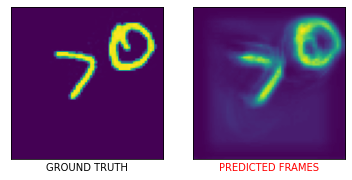

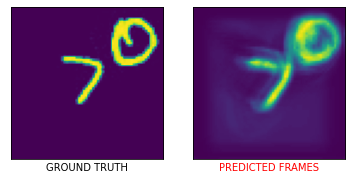

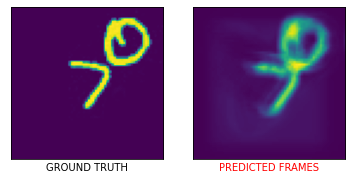

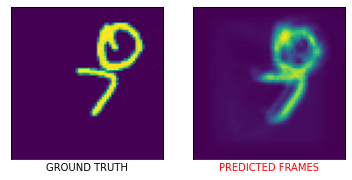

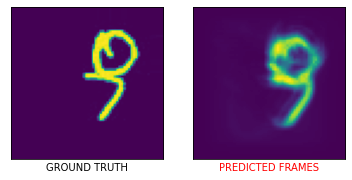

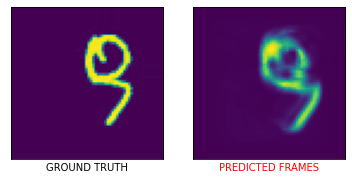

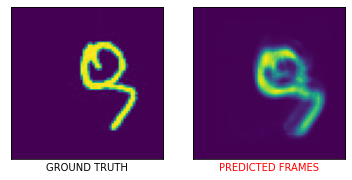

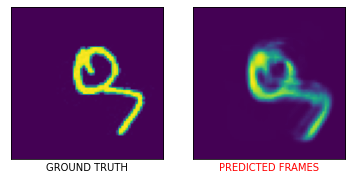

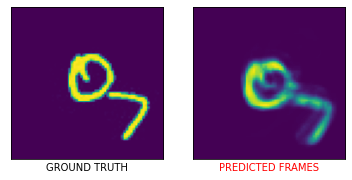

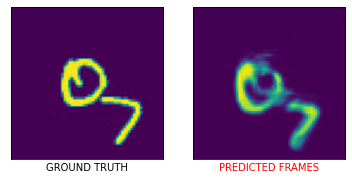

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Plot comparison
fig=plt.figure(figsize=(10, 15))
for i in range(10):
  ground_truth = Image.open('/content/drive/MyDrive/new_conv_lstm_mnist_prediction/'+str(i)+'_truth.png')
  predictions = Image.open('/content/drive/MyDrive/new_conv_lstm_mnist_prediction/'+str(i)+'_predict.png')
  f, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(ground_truth)
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_xlabel('GROUND TRUTH')
  ax2.imshow(predictions)
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xlabel('PREDICTED FRAMES', color='r')
  f.savefig('/content/drive/MyDrive/new_conv_lstm_mnist_prediction/comparison'+str(i)+'.png', tight=True)

## Creating video from predicted frames

In [ ]:
import cv2
import numpy as np
from cv2 import VideoWriter, VideoWriter_fourcc
width = 432
height = 288
width2 = 64
height2 = 64
FPS = 5 #Saniyedeki frame sayısı azaltılarak saniye artırılabilir.
fourcc = VideoWriter_fourcc(*'mp4v')
name='/content/drive/MyDrive/predicted_videos/newconvlstmmnist_comparison.mp4'
name2='/content/drive/MyDrive/predicted_videos/newconvlstmmnist_predicted.mp4'
video = VideoWriter(name, fourcc, float(FPS), (width, height))
video2 = VideoWriter(name2, fourcc, float(FPS), (width2, height2))
for i in range(10):
  img = cv2.imread('/content/drive/MyDrive/new_conv_lstm_mnist_prediction/comparison{}.png'.format(i))
  video.write(img)
  img2 = cv2.imread('/content/drive/MyDrive/new_conv_lstm_mnist_prediction/{}_predict.png'.format(i))
  video2.write(img2)
video.release()
video2.release()